In [100]:
import torch
from torchvision import datasets
data_path = "../data/cifar-10/"

cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [101]:
# Get data example

# CIFAR 10 class names in order (not provided by book)
class_names = [
    "Airplane",
    "Automobile",
    "Bird",
    "Cat",
    "Deer",
    "Dog",
    "Frog",
    "Horse",
    "Ship",
    "Truck"
]

img, label = cifar10[99]
img, label, class_names[label]

(<PIL.Image.Image image mode=RGB size=32x32 at 0x7F73706DFF28>,
 1,
 'Automobile')

In [102]:
# See class hierarchy of provided datasets

type(cifar10).__mro__

(torchvision.datasets.cifar.CIFAR10,
 torchvision.datasets.vision.VisionDataset,
 torch.utils.data.dataset.Dataset,
 object)

In [103]:
len(cifar10)

50000

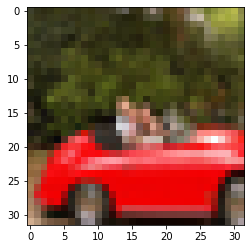

In [104]:
import matplotlib.pyplot as plt

plt.imshow(img)
plt.show()

In [105]:
"""
Albumentations is apparently a lot more feature-rich at the moment,
but you can use raw PyTorch transforms if you want.
"""

from torchvision import transforms
dir(transforms)

['CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'FiveCrop',
 'Grayscale',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandomAffine',
 'RandomApply',
 'RandomChoice',
 'RandomCrop',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomOrder',
 'RandomPerspective',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSizedCrop',
 'RandomVerticalFlip',
 'Resize',
 'Scale',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'functional',
 'functional_pil',
 'functional_tensor',
 'transforms']

In [106]:
# ToTensor transform

to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape, img_t.dtype

(torch.Size([3, 32, 32]), torch.float32)

In [107]:
# To Tensor also scales down the pixel values to 0.0 - 1.0

img_t.min(), img_t.max()

(tensor(0.), tensor(1.))

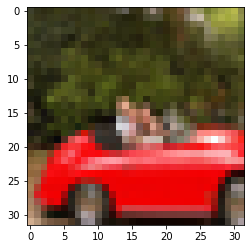

In [108]:
# But nothing has changed in the representation of the data

plt.imshow(img_t.permute(1, 2, 0))
plt.show()

In [109]:
# Transform the entire dataset accordingly using tranforms.Compose()

tensor_cifar10 = datasets.CIFAR10(
    data_path,
    train=True,
    download=False,
    transform=transforms.ToTensor()
)

img_t, _ = tensor_cifar10[99]
type(img_t)

torch.Tensor

In [110]:
# Normalizing the dataset using torch.transforms

# Stack all tensors from the dataset along an extra dimension

imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [111]:
# Compute mean per channel

"""
NOTE: view(3, -1) keeps the three channels and
merges all the remaining dimensions into one, figuring
out the appropriate size. Here our 3 × 32 × 32 image is
transformed into a 3 × 1,024 vector, and then the mean
is taken over the 1,024 elements of each channel
"""
imgs.view(3, -1).mean(dim=1)

tensor([0.4915, 0.4823, 0.4468])

In [112]:
# Compute standard deviation

imgs.view(3, -1).std(dim=1)

tensor([0.2470, 0.2435, 0.2616])

In [113]:
# Initialise the Normalize transform

transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))

Normalize(mean=(0.4915, 0.4823, 0.4468), std=(0.247, 0.2435, 0.2616))

In [114]:
# Add to dataset transforms
transformed_cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))
    ])
)

transformed_cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))
    ])
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


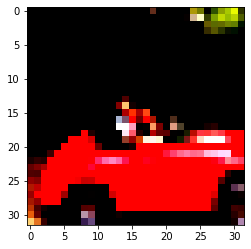

In [115]:
# Notice that normalization of the data changes the look of an image,
# but it is still represented the same within the normalized dataset
# (no representative data is lost)

img_t, _ = transformed_cifar10[99]

plt.imshow(img_t.permute(1, 2, 0))
plt.show()

In [116]:
# Binary classification task - birds vs airplanes

label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [
    (img, label_map[label])
    for img, label in transformed_cifar10
    if label in [0, 2]
]

cifar2_val = [
    (img, label_map[label])
    for img, label in transformed_cifar10_val
    if label in [0, 2]
]

In [117]:
# Define linear classifier model

import torch.nn as nn

n_out = 2

model = nn.Sequential(
    nn.Linear(
        3072,
        512,
    ),
    nn.Tanh(),
    nn.Linear(
        512,
        n_out
    )
)

In [118]:
# We can use the softmax function to represent the output of this model as a set of 
# probabilities over the classes

# Hand-coded softmax

def softmax(x):
    return torch.exp(x) / torch.exp(x).sum()

x = torch.tensor([1.0, 2.0, 3.0])

softmax(x), softmax(x).sum()

(tensor([0.0900, 0.2447, 0.6652]), tensor(1.))

In [119]:
# torch.nn also provides an implementation of softmax

softmax = nn.Softmax(dim=1)

x = torch.tensor([[
    1.0, 2.0, 3.0],
    [1.0, 2.0, 3.0]
])

softmax(x)

tensor([[0.0900, 0.2447, 0.6652],
        [0.0900, 0.2447, 0.6652]])

In [120]:
# We can use this to equip the previously defined network to predict probabilities

model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.Softmax(dim=1)
)

In [121]:
img, _ = cifar2[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


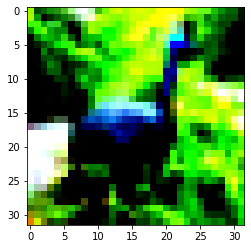

In [122]:
plt.imshow(img.permute(1, 2, 0))
plt.show()

In [123]:
# Reshape into batch

img_batch = img.view(-1).unsqueeze(0)

In [127]:
out = model(img_batch)
out

tensor([[0.6171, 0.3829]], grad_fn=<SoftmaxBackward>)

In [128]:
# argmax

_, index = torch.max(out, dim=1)
index

tensor([0])

In [129]:
"""
Use LogSoftmax for input of probabilities to NNLLoss (suitable
for penalising misclassifications without requiring specific/perfect values)
"""

model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1)
)

loss = nn.NLLLoss()

In [132]:
img, label = cifar2[0]

out = model(img.view(-1).unsqueeze(0))

loss(out, torch.tensor([label]))

tensor(0.5951, grad_fn=<NllLossBackward>)

In [135]:
# Time to train!

import torch.optim as optim

learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

n_epochs = 100

for epoch in range(n_epochs):
    for img, label in cifar2:
        out = model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out, torch.tensor([label]))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # NOTE: only prints loss for the last image
    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 3.937595
Epoch: 1, Loss: 4.837887
Epoch: 2, Loss: 6.719351
Epoch: 3, Loss: 0.530340
Epoch: 4, Loss: 1.772052
Epoch: 5, Loss: 9.820118
Epoch: 6, Loss: 10.393757
Epoch: 7, Loss: 7.213570
Epoch: 8, Loss: 0.362014
Epoch: 9, Loss: 3.891110
Epoch: 10, Loss: 0.927570
Epoch: 11, Loss: 6.235433
Epoch: 12, Loss: 10.908489
Epoch: 13, Loss: 8.189256
Epoch: 14, Loss: 15.977868
Epoch: 15, Loss: 13.795802
Epoch: 16, Loss: 10.330498
Epoch: 17, Loss: 6.408093
Epoch: 18, Loss: 7.517673
Epoch: 19, Loss: 17.074593
Epoch: 20, Loss: 7.975914
Epoch: 21, Loss: 10.123369
Epoch: 22, Loss: 10.465354
Epoch: 23, Loss: 15.724527
Epoch: 24, Loss: 8.502681
Epoch: 25, Loss: 8.152243
Epoch: 26, Loss: 15.641790
Epoch: 27, Loss: 13.589412
Epoch: 28, Loss: 2.115486
Epoch: 29, Loss: 6.068336
Epoch: 30, Loss: 2.306378
Epoch: 31, Loss: 5.903076
Epoch: 32, Loss: 2.219535
Epoch: 33, Loss: 10.317181
Epoch: 34, Loss: 12.812991
Epoch: 35, Loss: 23.716728
Epoch: 36, Loss: 18.590942
Epoch: 37, Loss: 10.982252
Epoch:

In [136]:
# Adapting the training code to use a dataloader

# Reinit all so we don't train on top of the same weights
model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1)
)

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.NLLLoss()

train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

# This can be used to iterate over in the training loop

for epoch in range(n_epochs):
    for imgs, labels in train_loader:
        
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        loss = loss_fn(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Due to shuffling, we now print loss for a random batch
    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.309271
Epoch: 1, Loss: 0.619634
Epoch: 2, Loss: 0.607700
Epoch: 3, Loss: 0.261380
Epoch: 4, Loss: 0.398284
Epoch: 5, Loss: 0.416269
Epoch: 6, Loss: 0.227701
Epoch: 7, Loss: 0.437984
Epoch: 8, Loss: 0.490072
Epoch: 9, Loss: 0.292526
Epoch: 10, Loss: 0.274726
Epoch: 11, Loss: 0.282889
Epoch: 12, Loss: 0.529629
Epoch: 13, Loss: 0.204691
Epoch: 14, Loss: 0.273864
Epoch: 15, Loss: 0.442601
Epoch: 16, Loss: 0.194993
Epoch: 17, Loss: 0.366086
Epoch: 18, Loss: 0.244123
Epoch: 19, Loss: 0.363626
Epoch: 20, Loss: 0.416254
Epoch: 21, Loss: 0.217713
Epoch: 22, Loss: 0.143859
Epoch: 23, Loss: 0.156243
Epoch: 24, Loss: 0.265013
Epoch: 25, Loss: 0.107251
Epoch: 26, Loss: 0.230154
Epoch: 27, Loss: 0.382818
Epoch: 28, Loss: 0.285165
Epoch: 29, Loss: 0.171841
Epoch: 30, Loss: 0.167570
Epoch: 31, Loss: 0.264420
Epoch: 32, Loss: 0.153694
Epoch: 33, Loss: 0.062301
Epoch: 34, Loss: 0.238585
Epoch: 35, Loss: 0.248624
Epoch: 36, Loss: 0.067809
Epoch: 37, Loss: 0.150447
Epoch: 38, Loss: 0.135

In [139]:
# Time to compute accuracy on the val dataset

val_loader = torch.utils.data.DataLoader(
    cifar2_val,
    batch_size=64,
    shuffle=False
)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        outputs = model(imgs.view(batch_size, -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.825500


In [ ]:
"""
As the combination of LogSoftmax and NLLLoss is equivalent to cross-entropy loss,
it's common to drop LogSoftmax and use CEL instead.

However, the outputs of the model will then not be interpretable as probabilities.
They'll need to pass through a regular Softmax layer to be so.
"""

model = nn.Sequential(
    nn.Linear(3072, 1024),
    nn.Tanh(),
    nn.Linear(1024, 512),
    nn.Tanh(),
    nn.Linear(512, 128),
    nn.Tanh(),
    nn.Linear(128, 2)
)

loss_fn = nn.CrossEntropyLoss()

In [140]:
"""
We can use numel() to count the number of parameters in an individual tensor.
Checking requires_grad() can allow us to isolate specifically trainable parameters
if this is important.
"""

# Trainable params of above model
numel_list = [p.numel() for p in model.parameters() if p.requires_grad == True]
sum(numel_list), numel_list

(1574402, [1572864, 512, 1024, 2])

Not doing the exercises for this chapter because it's a little basic.